In [1]:
import numpy as np 
import pandas as pd 
import keras
from sklearn.model_selection import train_test_split
from math import nan
from keras.callbacks import ModelCheckpoint
from future.utils import iteritems
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from subprocess import check_output
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k

Using TensorFlow backend.


  Cloning https://www.github.com/keras-team/keras-contrib.git to /private/var/folders/dx/_bt2j1p91sjf3jhvjlmckjl00000gn/T/pip-req-build-kc56g3dz
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /private/var/folders/dx/_bt2j1p91sjf3jhvjlmckjl00000gn/T/pip-req-build-kc56g3dz
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0


In [5]:
datasets = pd.read_csv('train_data/conll.txt', sep=" ", 
                         names = ["word", "POS_tag","chunk_tag", "NER_tag", "Sentence #"],
                         index_col = False)
datasets = datasets.dropna()
datasets = datasets[['Sentence #', 'word', 'NER_tag']]

In [6]:
def Characteristics(word, caseLookup):

    numDigits = 0
    for char in word:
        if char.isdigit():
            numDigits += 1

    digitFraction = numDigits / float(len(word))

    if word.isdigit():  # Is a digit
        casing = 'numeric'
    elif digitFraction > 0.5:
        casing = 'mainly_numeric'
    elif word.islower():  # All lower case
        casing = 'allLower'
    elif word.isupper():  # All upper case
        casing = 'allUpper'
    elif word[0].isupper():  # is a title, initial char upper, then all lower
        casing = 'initialUpper'
    elif numDigits > 0:
        casing = 'contains_digit'

    return caseLookup[casing]

In [8]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, n) for w, n in zip(s["word"].values.tolist(),
                                                        s["NER_tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(datasets)
sentences = getter.sentences

In [14]:
maxLen = max([len(s) for s in sentences])
words = list(set(datasets["word"].values))
words.append("ENDPAD")
nWords = len(words)

tags = []
for tag in set(datasets["NER_tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
nTags = len(tags)

In [34]:
case2Idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
            'contains_digit': 6, 'PADDING_TOKEN': 7}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')

char2Idx = {"PADDING": 0, "UNKNOWN": 1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
    char2Idx[c] = len(char2Idx)

In [36]:
word2Idx = {}
wordEmbeddings = []

fEmbeddings = open("glove.6B.50d.txt", encoding="utf-8")

# loop through each word in embeddings
for line in fEmbeddings:
    split = line.strip().split(" ")
    word = split[0]  # embedding word entry

    if len(word2Idx) == 0:  # add padding+unknown
        word2Idx["PADDING_TOKEN"] = len(word2Idx)
        vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
        wordEmbeddings.append(vector)

        word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
        wordEmbeddings.append(vector)

    if split[0].lower() in words:
        vector = np.array([float(num) for num in split[1:]])
        wordEmbeddings.append(vector)  # word embedding vector
        word2Idx[split[0]] = len(word2Idx)  # corresponding word dict

In [13]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

X = [[word2idx[words[0]] for words in s] for s in sentences]
X = pad_sequences(maxlen = 150, sequences = X, padding="post", value = nWords - 1)
yID = [[tag2idx[words[1]] for words in s] for s in sentences]
y = pad_sequences(maxlen = 150, sequences = yID, padding = "post", value = tag2idx["O"])

y = [to_categorical(i, num_classes = nTags) for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
inputLayer = Input(shape=(150,))
wordEmbeddingSize = 400
model = Embedding(input_dim = nWords, output_dim = wordEmbeddingSize, input_length = 150)(inputLayer)

model = Bidirectional(LSTM(units = wordEmbeddingSize, 
                           return_sequences=True, 
                           dropout = 0.2, 
                           recurrent_dropout = 0.3, 
                           kernel_initializer = k.initializers.he_normal()))(model)

model = LSTM(units = wordEmbeddingSize * 2, 
             return_sequences = True, 
             dropout = 0.2, 
             recurrent_dropout = 0.3, 
             kernel_initializer = k.initializers.he_normal())(model)

model = TimeDistributed(Dense(nTags, activation="relu"))(model)  

crf = CRF(nTags)  
outPut = crf(model)  

In [19]:
model = Model(inputLayer, outPut)

In [15]:
adam = k.optimizers.Adam(lr = 0.0005, beta_1 = 0.5, beta_2 = 0.5)
model.compile(optimizer = adam, loss = crf.loss_function, metrics=[crf.accuracy, 'acc'])

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 300)          4622100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 600)          1442400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 140, 600)          2882400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 4)            2404      
_________________________________________________________________
crf_1 (CRF)                  (None, 140, 4)            44        
Total params: 8,949,348
Trainable params: 8,949,348
Non-trainable params: 0
_________________________________________________

In [17]:
filepath="ner-bi-lstm-td-model-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [18]:
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Train on 4752 samples, validate on 1189 samples
Epoch 1/20
4752/4752 [==============================] - 514s 108ms/step - loss: 0.1042 - crf_viterbi_accuracy: 0.9673 - acc: 0.0073 - val_loss: 0.0967 - val_crf_viterbi_accuracy: 0.9672 - val_acc: 0.9673

Epoch 00001: acc improved from -inf to 0.00731, saving model to ner-bi-lstm-td-model-0.97.hdf5
Epoch 2/20
4752/4752 [==============================] - 518s 109ms/step - loss: 0.0887 - crf_viterbi_accuracy: 0.9692 - acc: 0.0073 - val_loss: 0.0849 - val_crf_viterbi_accuracy: 0.9688 - val_acc: 0.9689

Epoch 00002: acc did not improve from 0.00731
Epoch 3/20
4752/4752 [==============================] - 526s 111ms/step - loss: 0.0779 - crf_viterbi_accuracy: 0.9712 - acc: 0.0073 - val_loss: 0.0760 - val_crf_viterbi_accuracy: 0.9708 - val_acc: 0.9710

Epoch 00003: acc did not improve from 0.00731
Epoch 4/20
4752/4752 [==============================] - 522s 110ms/step - loss: 0.0692 - crf_viterbi_accuracy: 0.9731 - acc: 0.0073 - val_loss: 0.0691

In [27]:
his = pd.DataFrame(history.history)

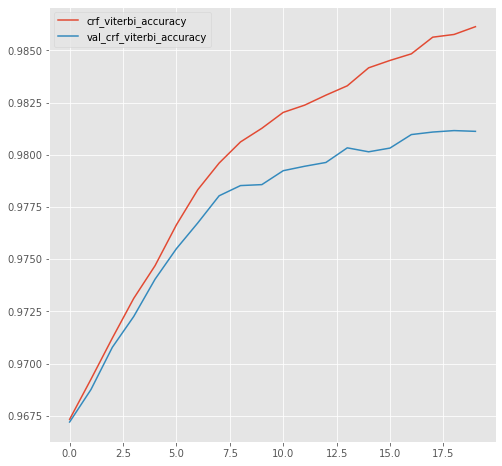

In [32]:
plt.style.use("ggplot")
plt.figure(figsize=(8,8))
plt.plot(his["crf_viterbi_accuracy"], label = "crf_viterbi_accuracy")
plt.plot(his["val_crf_viterbi_accuracy"], label = 'val_crf_viterbi_accuracy')
plt.legend(loc="upper left")
plt.show()

In [21]:
p = model.predict(np.array(X_test))  

In [24]:
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

        test       0.47      0.37      0.42      1501
     problem       0.79      0.85      0.82      3319
           O       0.99      1.00      0.99    201496
   treatment       0.00      0.00      0.00      1724

    accuracy                           0.98    208040
   macro avg       0.56      0.55      0.56    208040
weighted avg       0.97      0.98      0.98    208040



/opt/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
